Notebook Contents:

1. Train test split

2. Simple EDA
  * Descriptive statistics and data cleaning
  * Numerical features
  * Categorical features

3. Model variations
  * Apply One-hot encoding
  * Apply Square root transformation
  * Apply Standard scaling
  * Add Polynomial features

4. Cross-validation and Regularization
  * Linear Regression
  * Lasso Regression (L1)
  * Ridge Regression (L2)
  * Elastic Net Regression (L1 + L2)
  * Compare the metrics

5. Predict on the test set
  * Scatter plots of four models
  * Feature importance

6. Conclusion


##1. Train test split

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

# Mute the setting wtih a copy warnings
pd.options.mode.chained_assignment = None

In [2]:
data = pd.read_csv(r'/content/skoda.csv')

In [3]:
data.shape

(6267, 9)

In [4]:
data = data.drop_duplicates(keep='first').reset_index(drop=True)
data.shape

(6188, 9)

In [5]:
# Split the data to use the training set only
# Keep the test set unseen
from sklearn.model_selection import train_test_split
train_and_val, test = train_test_split(data, test_size=0.2, random_state=0)
print(f'Training and validation set size: {train_and_val.shape}')
print(f'Test set size: {test.shape}')

Training and validation set size: (4950, 9)
Test set size: (1238, 9)


In [7]:
train, val = train_test_split(train_and_val, test_size=0.25, random_state=0)
print(f'Training set size: {train.shape}')
print(f'Validation set size: {val.shape}')

Training set size: (3712, 9)
Validation set size: (1238, 9)


## 2. Simple EDA

Descriptive statistics and data cleaning

In [8]:
# Print out first 5 rows
train.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
2770,Superb,2020,33995,Semi-Auto,6063,Hybrid,135,176.6,1.4
3513,Superb,2019,25250,Automatic,8500,Petrol,145,38.2,2.0
3506,Superb,2014,9795,Semi-Auto,56420,Diesel,145,53.3,2.0
5079,Fabia,2018,10000,Manual,20965,Petrol,150,57.7,1.0
442,Superb,2019,29695,Automatic,5000,Petrol,145,38.2,2.0


In [10]:
# Training set info
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3712 entries, 2770 to 145
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         3712 non-null   object 
 1   year          3712 non-null   int64  
 2   price         3712 non-null   int64  
 3   transmission  3712 non-null   object 
 4   mileage       3712 non-null   int64  
 5   fuelType      3712 non-null   object 
 6   tax           3712 non-null   int64  
 7   mpg           3712 non-null   float64
 8   engineSize    3712 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 290.0+ KB


,year,price,mileage,tax,mpg,engineSize
count,3712.000000,3712.000000,3712.000000,3712.000000,3712.000000,3712.000000
mean,2017.490302,14266.005657,20246.272091,119.000539,56.567619,1.433890
std,1.750517,6196.224338,20080.575330,52.218996,12.261953,0.396154
min,2004.000000,995.000000,5.000000,0.000000,30.100000,0.000000
25%,2017.000000,9495.000000,5995.500000,125.000000,50.400000,1.000000
50%,2018.000000,13012.500000,14623.000000,145.000000,57.700000,1.400000
75%,2019.000000,17990.000000,28000.000000,145.000000,62.800000,2.000000
max,2020.000000,38990.000000,300000.000000,325.000000,201.800000,2.500000


In [11]:
# Add in new feature age, and remove year
# The data were collected in 2020, so the age column is calculated from this year
train = train[train['year'] <= 2020]
train['age'] = 2020 - train['year']
train = train.drop(['year'], axis=1)

In [12]:
# Determine columns by data types
cat_mask = (train.dtypes == np.object)
num_mask = (train.dtypes == np.float64) | (train.dtypes == np.int64)

cat_cols = train.columns[cat_mask].tolist()
num_cols = train.columns[num_mask].tolist()

print(f'Categorical columns: {cat_cols}')
print(f'Numerical columns: {num_cols}')

Categorical columns: ['model', 'transmission', 'fuelType']
Numerical columns: ['price', 'mileage', 'tax', 'mpg', 'engineSize', 'age']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  



### Numerical features

In [13]:
# Create a plotting function
def hist_loop(data: pd.DataFrame,
              rows: int,
              cols: int,
              figsize: tuple):

    """ Returns multiple histograms as subplots
    """
    fig, axes = plt.subplots(rows,cols, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):
        if i < len(data.columns):
            data[sorted(data.columns)[i]].plot.hist(bins=30, ax=ax)
            ax.set_title(f'{sorted(data.columns)[i]} distribution')
            ax.tick_params(axis='x')
            ax.tick_params(axis='y')
            ax.get_yaxis().get_label().set_visible(False)
        else:
            fig.delaxes(ax=ax)
    fig.tight_layout()

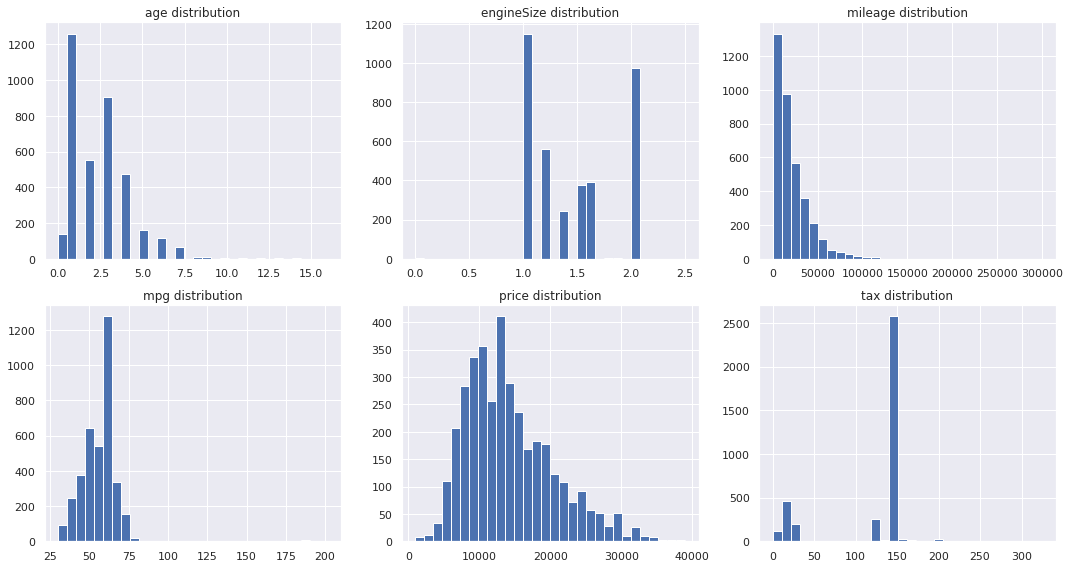

In [14]:
# Plot all numerical features
hist_loop(data=train[num_cols],
          rows=2,
          cols=3,
          figsize=(15,8))

In [15]:
#check skewness
def skew_df(data: pd.DataFrame, skew_limit: float) -> pd.DataFrame:
    # Define a limit above which we will transform
    skew_vals = data.skew()

    # Showing the skewed columns
    skew_cols = (skew_vals
                 .sort_values(ascending=False)
                 .to_frame('Skew')
                 .query('abs(Skew) > {}'.format(skew_limit))
    )
    return skew_cols
skew_cols = skew_df(train[num_cols], 0.75)
skew_cols

,Skew
mpg,4.009148
mileage,2.741412
age,1.555632
price,0.839195
tax,-1.312816


In [16]:
# Apply square root transformation on predictors only
train_sqrt = train[num_cols].drop('price', axis=1).copy()
for col in list(skew_cols.index):
    if col != 'price':
        train_sqrt[col] = train_sqrt[col].apply(np.sqrt)

# Check again
skew_df(train_sqrt, 0.75)

,Skew
mpg,1.450890
tax,-1.634658


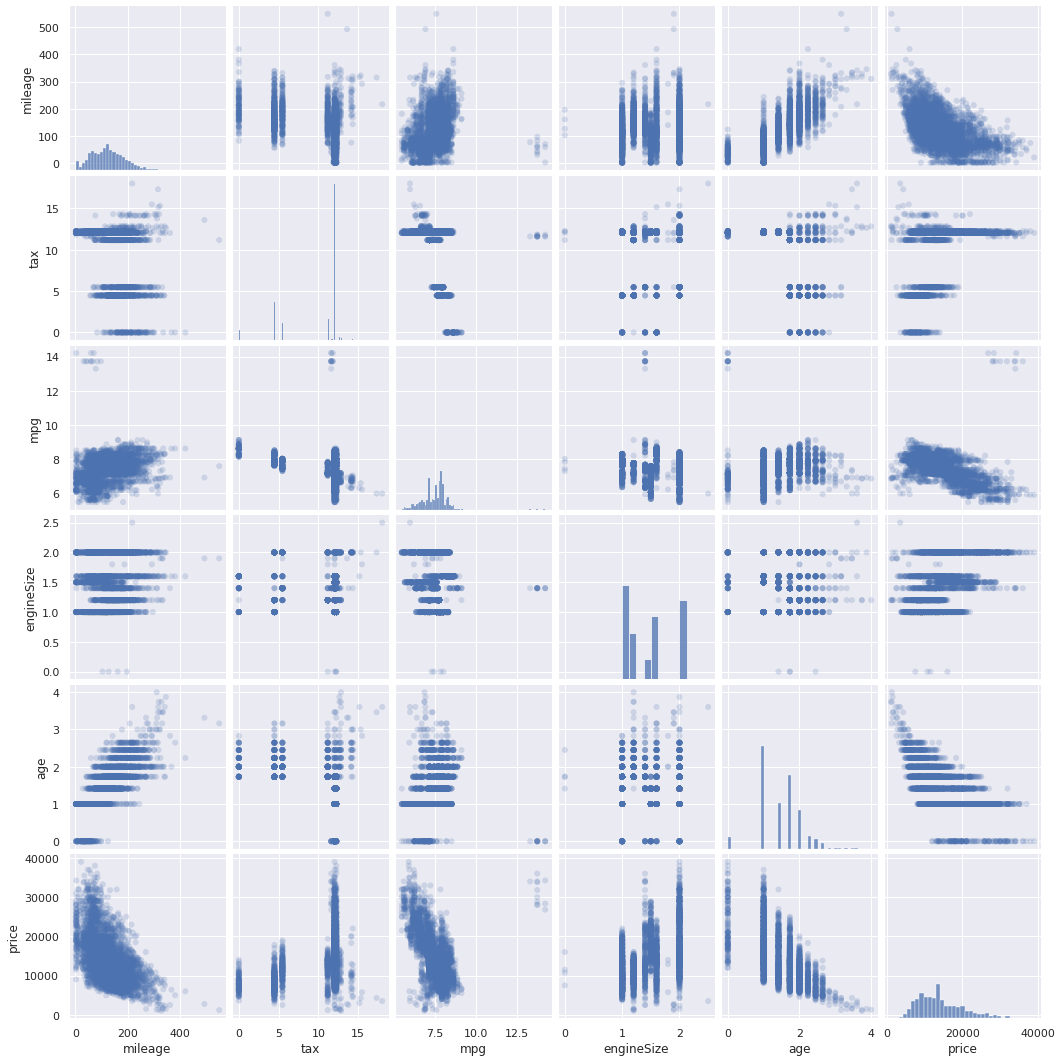

In [17]:
# Pairplot of transformed features and the target
sns.pairplot(train_sqrt.join(train['price']), plot_kws=dict(alpha=.2, edgecolor='none'));



This plot shows that:

    1.age has a linear relationship with price. It looks quite like polynomial.
    2.age also has a linear relationship with mileage (the older the more miles). This is multicollinearity.

Let's see how severe the multicollinearity is.


In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

calc_vif(train_sqrt)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,variables,VIF
0,mileage,12.149849
1,tax,10.433026
2,mpg,26.840992
3,engineSize,12.639103
4,age,18.392965



The features have high multicollinearity. This problem might be resolved by regularization later.

##Categorical features

In this part, I will check the data integrity and also plot some boxplots to see how price is different among these categories. But I will not perform much analysing to find combined relationship or correlation.

These plots are based on price values before transformation.


In [19]:
train.describe(include=np.object)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


,model,transmission,fuelType
count,3712,3712,3712
unique,12,3,4
top,Fabia,Manual,Petrol
freq,928,2178,2481


In [20]:
# Print out all unique model names
list(train['model'].unique())

[' Superb',
 ' Fabia',
 ' Octavia',
 ' Yeti Outdoor',
 ' Citigo',
 ' Rapid',
 ' Scala',
 ' Kodiaq',
 ' Karoq',
 ' Kamiq',
 ' Yeti',
 ' Roomster']

In [21]:
# Remove leading spaces
train['model'] = train['model'].str.strip(' ')

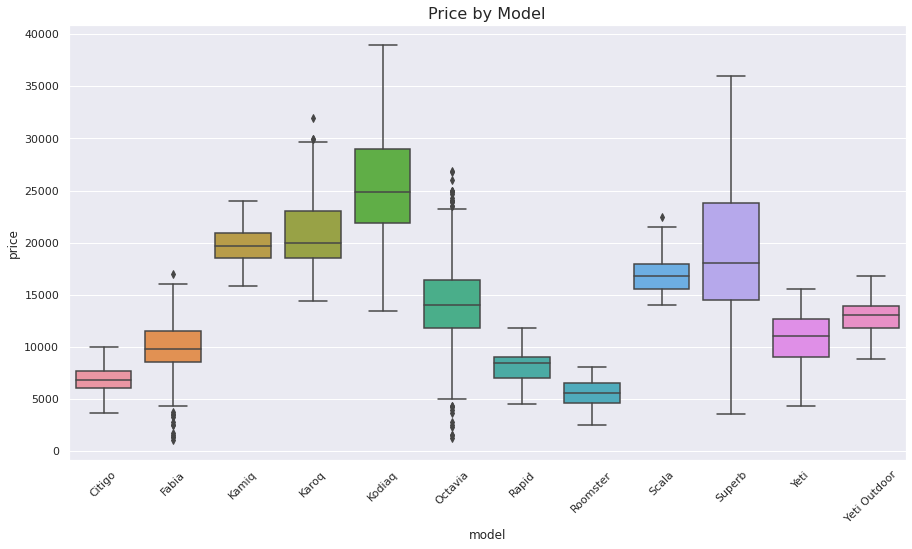

In [22]:
# Boxplot of model and price
fig, ax = plt.subplots(figsize=(15,8))
order = sorted(list(train['model'].unique()))
sns.boxplot(x='model', y='price', data=train, order=order, ax=ax)
plt.xticks(rotation=45)
plt.title('Price by Model', fontsize=16)
plt.show()

In [24]:
list(train['transmission'].unique())

['Semi-Auto', 'Automatic', 'Manual']

In [25]:
list(train['fuelType'].unique())


['Hybrid', 'Petrol', 'Diesel', 'Other']

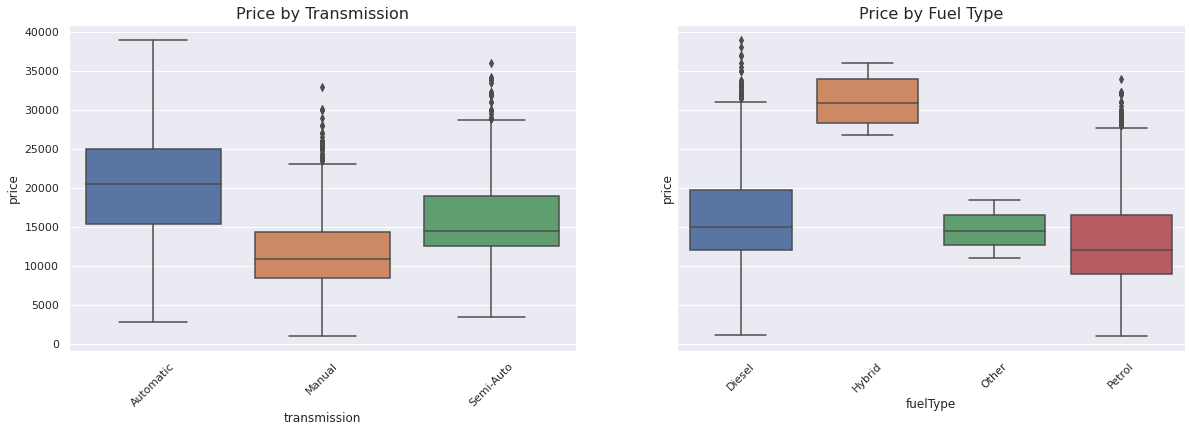

In [26]:
# Box plots of price and tranmission/ fuel type
fig, ax = plt.subplots(1, 2, figsize=(20,6), sharey=True)
order0 = sorted(list(train['transmission'].unique()))
sns.boxplot(x='transmission', y='price', data=train, order=order0, ax=ax[0])
ax[0].set_title('Price by Transmission', fontsize=16)
ax[0].tick_params('x', labelrotation=45)

order1 = sorted(list(train['fuelType'].unique()))
sns.boxplot(x='fuelType', y='price', data=train, order=order1, ax=ax[1])
ax[1].set_title('Price by Fuel Type', fontsize=16)
ax[1].tick_params('x', labelrotation=45)
plt.show()



On average, car prices are different among models, transmission, and fuel types.
##3. Model variations

In this part, I will perform different feature engineering in an order, then fit the linear regression after each engineering step. The root mean square errors are stored and compared

In [27]:
# Copy the data from training and validation set
# Clean the data
df = train_and_val.copy()

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures

In [29]:
# Create a class for feature engineering and model fitting
class LR_model:

    # Default values
    target = 'price'
    test_size = 0.25
    random_state = 0
    skew_cols = ['engineSize', 'mileage', 'age']

    def __init__(self, data):
        self.train, self.test = train_test_split(data, test_size=LR_model.test_size, random_state=LR_model.random_state)
    
    def clean_data(self, df):

        """ Cleans the data"""

        df = df[df['year'] <= 2020]
        df['age'] = 2020 - df['year']
        df = df.drop(['year'], axis=1)
        df['model'] = df['model'].str.strip(' ')
        
        return df
        
    def oh_enc(self, X_train, X_test):

        """ Performs one-hot encoding and drops the first category
        """

        ENC = OneHotEncoder(handle_unknown='ignore', sparse=False)

        # Filter categorical features only
        X_train_cat = X_train.select_dtypes(include=['object'])
        X_test_cat = X_test.select_dtypes(include=['object'])

        # Fit one-hot encoding on training set
        # Transform both training set and test set
        X_train_enc = ENC.fit_transform(X_train_cat)
        X_test_enc = ENC.transform(X_test_cat)

        # Join dummy values with numerical features
        X_train_enc_df = pd.DataFrame(X_train_enc,
                                      index=X_train.index,
                                      columns=ENC.get_feature_names(X_train_cat.columns.tolist()))
        X_train = X_train_enc_df.join(X_train.select_dtypes(exclude=['object']))

        # Drop one column of each category
        for col in X_train_cat.columns.tolist():
            cat_cols = X_train.columns[X_train.columns.str.startswith(col)].tolist()
            if len(cat_cols) > 1:
                X_train = X_train.drop(cat_cols[0], axis=1)
        
        # Same steps for the test set
        X_test_enc_df = pd.DataFrame(X_test_enc,
                                     index=X_test.index,
                                     columns=ENC.get_feature_names(X_test_cat.columns.tolist()))
        X_test = X_test_enc_df.join(X_test.select_dtypes(exclude=['object']))
        for col in X_test_cat.columns.tolist():
            cat_cols = X_test.columns[X_test.columns.str.startswith(col)].tolist()
            if len(cat_cols) > 1:
                X_test = X_test.drop(cat_cols[0], axis=1)

        return X_train, X_test

    def sqrt_trans(self, X_train, X_test):

        """ Applies square root transformation for skewed features
        """
        X_train[LR_model.skew_cols] = X_train[LR_model.skew_cols].apply(np.sqrt)
        X_test[LR_model.skew_cols] = X_test[LR_model.skew_cols].apply(np.sqrt)

        return X_train, X_test

    def scale_X(self, X_train, X_test):

        """ Applies standard scaling for all numerical features
        """

        scaler = StandardScaler()

        # Filter numerical features only (excluding binary values)
        float_cols = X_train.columns[~X_train.isin([0,1]).all()].tolist()

        # Fit features in traning set and transform to test set
        X_train[float_cols] = scaler.fit_transform(X_train[float_cols])
        X_test[float_cols] = scaler.transform(X_test[float_cols])

        return X_train, X_test

    def add_pf(self, X_train, X_test, degree=None):

        """ Adds polynomial features into the dataset
        """
        
        PF = PolynomialFeatures(degree=degree, include_bias=False)

        # Filter numerical features only (excluding binary values)
        float_cols = X_train.columns[~X_train.isin([0,1]).all()].tolist()

        # Fit features in traning set and transform to test set
        X_train_pf = PF.fit_transform(X_train[float_cols])
        X_test_pf = PF.transform(X_test[float_cols])
        
        # Add non-numerical features back into the transformed training set
        X_train_pf_df = pd.DataFrame(X_train_pf,
                                     index=X_train.index,
                                     columns=PF.get_feature_names(input_features=float_cols))
        X_train = X_train_pf_df.join(X_train[X_train.columns[~X_train.columns.isin(float_cols)].tolist()])
        
       # Add non-numerical features back into the transformed test set
        X_test_pf_df = pd.DataFrame(X_test_pf,
                                    index=X_test.index,
                                    columns=PF.get_feature_names(input_features=float_cols))
        X_test = X_test_pf_df.join(X_test[X_test.columns[~X_test.columns.isin(float_cols)].tolist()])
        
        return X_train, X_test

    def rmse(self, y_true, y_predicted):

        """ Returns root mean squared error"""
        return np.sqrt(mean_squared_error(y_true, y_predicted))

    def model_fit(self, label=None,
                  encoding=False,
                  squareroot=False,
                  scaling=False,
                  polynomial=False,
                  degree=None):
        
        """ Fits linear regression model and returns 
        RMSE of training set and test set
        """

        # Split data
        train, test = self.clean_data(self.train), self.clean_data(self.test)
        X_train, X_test = train.drop(LR_model.target, axis=1), test.drop(LR_model.target, axis=1)
        y_train, y_test = train[LR_model.target], test[LR_model.target]

        # Perform feature engineering
        if encoding:
            X_train, X_test = self.oh_enc(X_train, X_test)

        if not encoding:
           X_train, X_test = X_train.select_dtypes(exclude=['object']), X_test.select_dtypes(exclude=['object'])

        if squareroot:
            X_train, X_test = self.sqrt_trans(X_train, X_test)

        if scaling:
            X_train, X_test = self.scale_X(X_train, X_test)
        
        if polynomial:
            X_train, X_test = self.add_pf(X_train, X_test, degree)
        
        num_features = X_train.shape[1]
        # Fit model and predict the target
        LR = LinearRegression()
        LR.fit(X_train, y_train)
        y_train_pred = LR.predict(X_train)
        y_test_pred = LR.predict(X_test)
        
        # Compute RMSE and store in a dictionary
        rmse_train = self.rmse(y_train, y_train_pred)
        rmse_test = self.rmse(y_test,  y_test_pred)
        scores = {
            'Model': label,
            'Number of features': num_features,
            'RMSE train': rmse_train,
            'RMSE test': rmse_test
        }
        
        return scores

##Apply One-hot encoding

In [30]:
# Fit LR model in each set and print out RMSE
error_df = [] # Blank error list to create a data frame later

# Fit non-encoded data
not_enc = LR_model(df).model_fit(label='not encoded')

# Fit encoded data
enc = LR_model(df).model_fit(label='one hot encoded', encoding=True)

# Print out error table
error_df = pd.DataFrame.from_dict([not_enc])
error_df = error_df.append(enc, ignore_index=True)
error_df

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Model,Number of features,RMSE train,RMSE test
0,not encoded,5,3182.800741,3351.251219
1,one hot encoded,21,1753.071972,1845.241214




The model that has encoded features performs better, which is understandable because it has more information to predict the target. RMSEs of test sets are slightly higher than training sets, which is expected. There is no sign of overfitting.
##Apply Square root transformation

In [31]:
# Fit non-encoded data
not_enc_bc = LR_model(df).model_fit(label='not encoded + squareroot', squareroot=True)

# Fit encoded data
enc_bc = LR_model(df).model_fit(label='one hot encoded + squareroot', encoding=True, squareroot=True)

# Print out error table
error_df = error_df.append([not_enc_bc, enc_bc], ignore_index=True)
error_df

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Model,Number of features,RMSE train,RMSE test
0,not encoded,5,3182.800741,3351.251219
1,one hot encoded,21,1753.071972,1845.241214
2,not encoded + squareroot,5,3126.277798,3293.862086
3,one hot encoded + squareroot,21,1771.605914,1837.651468




The transformation improves all models. The one that has encoded features is the best so far.
##Apply Standard scaling

Scaling features is a preparation for regularization later. RMSEs of both training set and test set should stay the same. From this point onwards, I will use the encoded data only.


In [32]:
# Fit encoded data
enc_bc_s = LR_model(df).model_fit(label='one hot encoded + squareroot + scaled', encoding=True, squareroot=True, scaling=True)

# Print out error table
error_df = error_df.append(enc_bc_s, ignore_index=True)
error_df

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Model,Number of features,RMSE train,RMSE test
0,not encoded,5,3182.800741,3351.251219
1,one hot encoded,21,1753.071972,1845.241214
2,not encoded + squareroot,5,3126.277798,3293.862086
3,one hot encoded + squareroot,21,1771.605914,1837.651468
4,one hot encoded + squareroot + scaled,21,1771.605914,1837.651468



###Add Polynomial features

As shown in the pairplot, there is a polynomial relationship between the target and engineSize. Let's try adding polynomial features to the latest model (encoded, square root transformed, and scaled).


In [33]:
# Create blank error table
error_pf_df = pd.DataFrame(columns=['Model', 'Number of features', 'RMSE train', 'RMSE test'])

# Iterate different degree, 1 to 10
for d in list(range(1,11)):
    error = LR_model(df).model_fit(label=f'Degree = {d}', encoding=True, scaling=True, polynomial=True, degree=d)
    error_pf_df = error_pf_df.append(error, ignore_index=True)

# Print out the error table
error_pf_df

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is d

,Model,Number of features,RMSE train,RMSE test
0,Degree = 1,21,1753.071972,1.845241e+03
1,Degree = 2,36,1545.863328,1.644948e+03
2,Degree = 3,71,1522.124393,1.615805e+03
3,Degree = 4,141,1465.982680,1.879222e+03
4,Degree = 5,267,1426.982470,6.537099e+03
5,Degree = 6,477,1358.916283,5.721435e+04
6,Degree = 7,807,1270.972297,2.830059e+06
7,Degree = 8,1302,1177.021105,1.445112e+10
8,Degree = 9,2017,1110.196277,1.845973e+11
9,Degree = 10,3018,2504.040594,1.793910e+11




It looks like the third polynomial degree transformation returns the best model. At degree 4 and above, as the model gets more and more complex, it starts overfitting.
###4. Cross-validation and Regularization

In this part, I use cross validation to fit the linear regression model again, and then attempt to tune the hyperparameter to find a proper alpha and polynomial degree combination for regularization.


In [35]:
# Import libraries
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn_pandas import DataFrameMapper, gen_features

In [36]:
# 5-fold cross validation
kf = KFold(shuffle=True, random_state=0, n_splits=5)

In [37]:
df = df[df['year'] <= 2020]
df['age'] = 2020 - df['year']
df = df.drop(['year'], axis=1)
df['model'] = df['model'].str.strip(' ')

X = df.drop('price', axis=1)
y = df['price']

In [38]:
# Create a class for data pipeline
class XPipe:
    # Skew features observed from the EDA
    skew_cols = ['engineSize', 'mileage', 'age']

    def __init__(self, X):
        self.cat_cols = X.select_dtypes(include=['object']).columns.tolist()
        self.num_cols = X.select_dtypes(exclude=['object']).columns.tolist()
        
    def drop_first(self, cat_values):

        """ Drops one category after one-hot encoding"""

        dummy_df = pd.DataFrame(cat_values)
        dummy_df = dummy_df.drop(0, axis=1)

        return dummy_df.values

    def sqrt_trans(self, num_values):

        """ Applies square root transformation to skewed features"""

        num_df = pd.DataFrame(num_values, columns=self.num_cols)
        num_df[XPipe.skew_cols] = num_df[XPipe.skew_cols].apply(np.sqrt)
        
        return num_df.values

    def model_pipe(self, model, degree=2):

        """ Returns a data pipeline"""

        cat_list = [[col] for col in self.cat_cols]
        cat_features = gen_features(
            columns=cat_list,
            classes=[{'class':OneHotEncoder, 'handle_unknown':'ignore', 'sparse':False},
                     {'class':FunctionTransformer, 'func': self.drop_first}]
        )
        
        mapper = DataFrameMapper((cat_features) + [  
            (self.num_cols, [FunctionTransformer(self.sqrt_trans),
                             StandardScaler(),
                             PolynomialFeatures(degree=degree, include_bias=False)])
        ])

        return make_pipeline(mapper, model)

In [40]:
XPipe(X).model_pipe(LinearRegression())

Pipeline(steps=[('dataframemapper',
                 DataFrameMapper(features=[(['model'],
                                            [OneHotEncoder(handle_unknown='ignore',
                                                           sparse=False),
                                             FunctionTransformer(func=<bound method XPipe.drop_first of <__main__.XPipe object at 0x7f8a030d1e50>>)]),
                                           (['transmission'],
                                            [OneHotEncoder(handle_unknown='ignore',
                                                           sparse=False),
                                             FunctionTransformer(func=<bound method XPipe.drop_first of <...
                                                           sparse=False),
                                             FunctionTransformer(func=<bound method XPipe.drop_first of <__main__.XPipe object at 0x7f8a030d1e50>>)]),
                                           (['

Now, let's go over each model: Linear regression, Lasso regression, Ridge regression, and Elastic Net regression. Each model will be evaluated based on its average root mean squared error (from 5 folds).

In [41]:
# Create a blank dictionary to store metrics of different models
metrics = {}

##Linear Regression

In the train test split part, adding the third degree polynomial features returns the best model. Let's see if cross-validation returns different results

In [42]:
# Blank dictionary to add in metrics
lr_scores = {}

# Iterate over different degrees, 1 to 6
for d in list(range(1,7)):
    score = cross_val_score(XPipe(X)
                            .model_pipe(LinearRegression(), degree=d),
                            X, y, cv=kf, scoring='neg_mean_squared_error')
    lr_scores[f'Degree = {d}'] = np.mean(np.sqrt(-score))

# Create an error table and print it out
lr_rmse = pd.DataFrame.from_dict(lr_scores, orient='index', columns=['Average RMSE']).sort_values('Average RMSE')
lr_rmse

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is d

,Average RMSE
Degree = 3,1.578591e+03
Degree = 2,1.601289e+03
Degree = 1,1.800010e+03
Degree = 4,2.381707e+03
Degree = 5,9.157710e+03
Degree = 6,1.696229e+06


In [43]:
# Calculate average R squared
lr_r2_scores = cross_val_score(XPipe(X)
                              .model_pipe(LinearRegression(), degree=3),
                              X, y, cv=kf)
lr_r2_scores

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is d

array([0.93727148, 0.93626832, 0.93957894, 0.9323772 , 0.93329529])

In [44]:
# Store the metrics
metrics['Average RMSE'] = [lr_rmse['Average RMSE'].values[0]]
metrics['Average R2'] = [np.mean(lr_r2_scores)]

## Lasso Regression (L1)

In [45]:
# Blank dictionary to add in metrics
las_scores = {}

# Iterate over different alphas
for d in [1, 2, 3]:
    for a in [0.005, 0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10]:
        score = cross_val_score(XPipe(X)
                                .model_pipe(Lasso(alpha=a, max_iter=100000), degree=d),
                                X, y, cv=kf, scoring='neg_mean_squared_error')
            
        las_scores[f'Degree = {d}, alpha = {a}'] = np.mean(np.sqrt(-score))

# Create an error table and print it out (first 5 rows)
las_rmse = pd.DataFrame.from_dict(las_scores, orient='index', columns=['Average RMSE']).sort_values('Average RMSE')
las_rmse.head(5)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is d

,Average RMSE
"Degree = 3, alpha = 0.005",1578.637617
"Degree = 3, alpha = 0.01",1578.686903
"Degree = 3, alpha = 0.05",1579.176681
"Degree = 3, alpha = 0.1",1579.992020
"Degree = 3, alpha = 1",1582.928074


In [51]:
# Calculate average R squared
las_r2_scores = cross_val_score(XPipe(X)
                                .model_pipe(Lasso(alpha=0.3, max_iter=100000), degree=3),
                                X, y, cv=kf)
las_r2_scores

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is d

array([0.93693207, 0.93589846, 0.9392216 , 0.93239212, 0.9322911 ])

In [52]:
# Store the metrics
metrics['Average RMSE'].append(ridge_rmse['Average RMSE'].values[0])
metrics['Average R2'].append(np.mean(ridge_r2_scores))

## Ridge Regression (L2)

In [46]:
# Blank dictionary to add in metrics
ridge_scores = {}

# Iterate over different alphas
for d in [1, 2, 3]:
    for a in [0.005, 0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10]:
        score = cross_val_score(XPipe(X)
                                .model_pipe(Ridge(alpha=a, max_iter=100000), degree=d),
                                X, y, cv=kf, scoring='neg_mean_squared_error')

                                
        ridge_scores[f'Degree = {d}, alpha = {a}'] = np.mean(np.sqrt(-score))

# Create an error table and print it out (first 5 rows)
ridge_rmse = pd.DataFrame.from_dict(ridge_scores, orient='index', columns=['Average RMSE']).sort_values('Average RMSE')
ridge_rmse.head(5)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is d

,Average RMSE
"Degree = 3, alpha = 0.005",1579.072845
"Degree = 3, alpha = 0.01",1579.505454
"Degree = 3, alpha = 0.05",1581.598381
"Degree = 3, alpha = 0.1",1582.736683
"Degree = 3, alpha = 0.3",1584.485312


In [47]:
# Calculate average R squared
ridge_r2_scores = cross_val_score(XPipe(X)
                                  .model_pipe(Ridge(alpha=0.005, max_iter=100000), degree=3),
                                  X, y, cv=kf)
ridge_r2_scores

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is d

array([0.93723572, 0.93624716, 0.93953219, 0.93236449, 0.93321363])

In [49]:
# Store the metrics
metrics['Average RMSE'].append(ridge_rmse['Average RMSE'].values[0])
metrics['Average R2'].append(np.mean(ridge_r2_scores))

## Elastic Net Regresstion (L1 + L2)

In [53]:
# Blank dictionary to add in metrics
elasticnet_scores = {}

# Iterate over different alphas
for d in [1, 2, 3]:
    for a in [0.005, 0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10]:
        score = cross_val_score(XPipe(X)
                                .model_pipe(ElasticNet(alpha=a, max_iter=100000), degree=d),
                                X, y, cv=kf, scoring='neg_mean_squared_error')
        elasticnet_scores[f'Degree = {d}, alpha = {a}'] = np.mean(np.sqrt(-score))

# Create an error table and print it out (first 5 rows)
elasticnet_rmse = pd.DataFrame.from_dict(elasticnet_scores, orient='index', columns=['Average RMSE']).sort_values('Average RMSE')
elasticnet_rmse.head(5)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is d

,Average RMSE
"Degree = 3, alpha = 0.005",1652.643671
"Degree = 2, alpha = 0.005",1666.886019
"Degree = 3, alpha = 0.01",1693.303691
"Degree = 2, alpha = 0.01",1709.415022
"Degree = 3, alpha = 0.05",1815.696255


In [54]:
# Calculate average R squared
elasticnet_r2_scores = cross_val_score(XPipe(X)
                                       .model_pipe(ElasticNet(alpha=0.005, max_iter=100000), degree=3),
                                       X, y, cv=kf)
elasticnet_r2_scores

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is d

array([0.93116464, 0.92942975, 0.93482185, 0.929049  , 0.9231944 ])

In [55]:
# Store the metrics
metrics['Average RMSE'].append(elasticnet_rmse['Average RMSE'].values[0])
metrics['Average R2'].append(np.mean(elasticnet_r2_scores))

## 5. Predict on the test set

In [56]:
# Keep the original data
train_df, test_df = train.copy(), test.copy()

In [57]:
# Clean the training set
X_train = train_df.drop('price', axis=1)
y_train = train_df['price']

In [58]:
# Clean the test set
test_df = test_df[test_df['year'] <= 2020]
test_df['age'] = 2020 - test_df['year']
test_df = test_df.drop(['year'], axis=1)
test_df['model'] = test_df['model'].str.strip(' ')

X_test = test_df.drop('price', axis=1)
y_test = test_df['price']

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is d

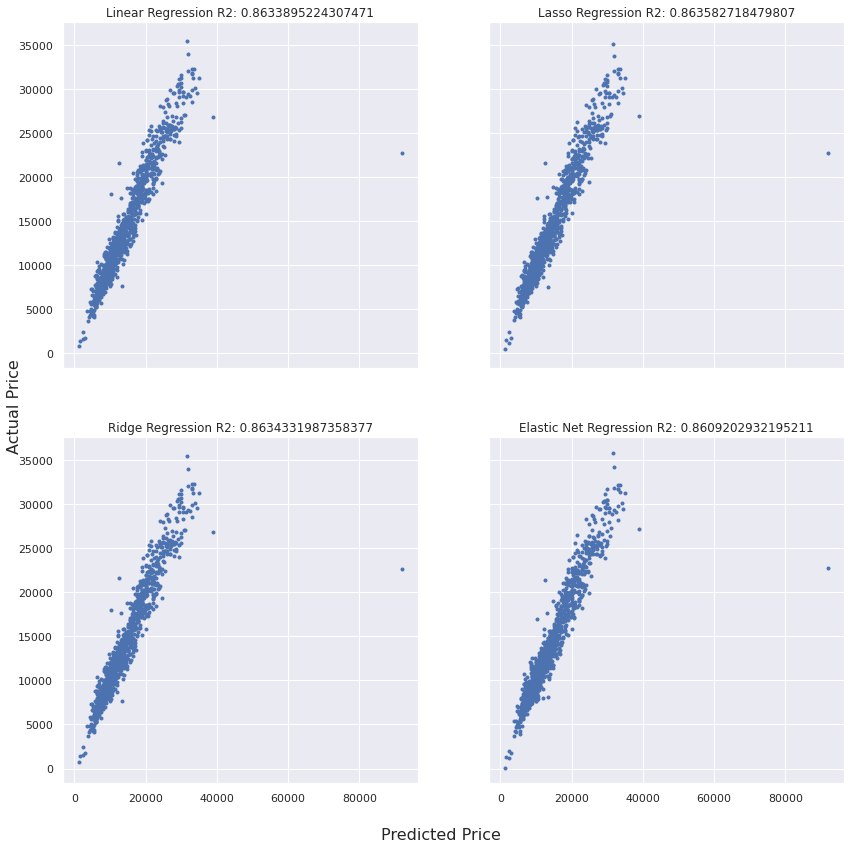

In [59]:
# Make prediction on the test set and plot four scatter plots separately

fig, axes = plt.subplots(2,2, figsize=(14,14), sharex=True, sharey=True)
fig.text(0.5, 0.07, 'Predicted Price', ha='center', fontdict={'size': 16})
fig.text(0.07, 0.5, 'Actual Price', va='center', rotation='vertical', fontdict={'size': 16})

models = [LinearRegression(), Lasso(alpha=0.3, max_iter=100000),
          Ridge(alpha=0.005, max_iter=100000), ElasticNet(alpha=0.005, max_iter=100000)]

labels = ['Linear', 'Lasso', 'Ridge', 'Elastic Net']

for i, ax in enumerate(axes.flatten()):
    y_pred = (XPipe(X_train)
              .model_pipe(models[i], degree=3)
              .fit(X_train, y_train)
              .predict(X_test))

    r_squared = r2_score(y_test, y_pred)

    ax.plot(y_test, y_pred, marker='o', ls='', ms=3.0)
    ax.set(title=f'{labels[i]} Regression R2: {r_squared}')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is d

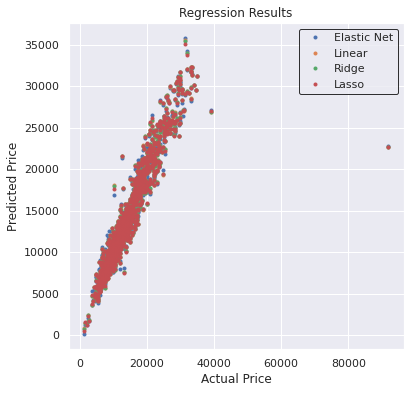

In [60]:
# Make prediction on the test set and plot one combined scatter plot

fig = plt.figure(figsize=(6,6))
ax = plt.axes()

models = [ElasticNet(alpha=0.005, max_iter=100000), LinearRegression(),
          Ridge(alpha=0.005, max_iter=100000), Lasso(alpha=0.3, max_iter=100000)]
         
labels = ['Elastic Net', 'Linear', 'Ridge', 'Lasso']

for mod, lab in zip(models, labels):
    y_pred = (XPipe(X_train)
              .model_pipe(mod, degree=3)
              .fit(X_train, y_train)
              .predict(X_test))
    ax.plot(y_test, y_pred, marker='o', ls='', ms=3.0, label=lab)

leg = plt.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(1.0)

ax.set(xlabel='Actual Price', 
       ylabel='Predicted Price', 
       title='Regression Results');

##6. Conclusion

This analysis shows that feature engineering can have a large effect on the model performance, and if the data are sufficiently large, cross-validation should be preferred over train-test-split to construct model evaluation. In my case, even though the predictors have high multicollinearity, their coefficients were not shrunk by the Lasso model, and it is shown that regularization does not always make big improvement on a given model. In the end, the Lasso regression has the highest

when predicting on the test set, and categories of car model appear to be the most important features to predict a car price. Also, Lasso did shrink some of the features that are not so important in terms of prediction.

While researching further analysis, I found a suggestion of using grouped Lasso when a model have categorical features, which is worth trying in this case.